# Inerpretation-Net Training

# Experiment 1: I-Net Performance for Different Algebras and Complexities
# Experiment 2: I-Net Performance Comparison for λ-Nets with Different Training Levels
# Experiment 3: I-Net Performance Comparison Different Training Data Sizes

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'data': {
        'd': 5, #degree
        'n': 1, #number of variables
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0.5,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 1000,
    },
    'i_net': {
        'optimizer': 'custom',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0.25,
        'epochs': 500,
        'early_stopping': True,
        'batch_size': 512,
        'dense_layers': [512, 1024],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': None, #(None, int)
        'interpretation_net_output_shape': None, #calculated automatically later
        
        'evaluate_with_real_function': False,
        'consider_labels_training': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': True,
        'nas_type': 'SEQUENTIAL', #options:(None, 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': True,
        'each_epochs_save_lambda': 20,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
    },
    'computation':{
        'n_jobs': 11,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

import logging

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.utils import plot_model
from IPython.display import Image

import keras.backend as K
from livelossplot import PlotLossesKerasTF
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf
import random 


import warnings


from IPython.display import display, Math, Latex



In [4]:
sys.path.append('..')

from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

logging.getLogger('tensorflow').disabled = True

sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

In [6]:
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis

config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d'])
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else 2*config['i_net']['interpretation_net_output_monomials']


transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sparsity')*config['data']['sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [7]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense512-1024-output_6_drop0.25e500b512_custom/lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_5_amin_-1_amax_1_xdist_uniform_noise_normal_0.5
lnets_10000_30-1000eES64b_adam_mae_train_1000_diffX_1-FixSeed_42/var_1_d_5_sparsity_5_amin_-1_amax_1_xmin_0_xmax_1_xdist_uniform_noise_normal_0.5


In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


layers_with_input_output = list(flatten([[n], lambda_network_layers, [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]

  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


  0%|          | 0/6 [00:00<?, ?it/s]

List length: 6
Number of monomials in a polynomial with 1 variables and degree 5: 6
Sparsity: 6
['0', '1', '2', '3', '4', '5']


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(index):
    
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
    
    path = './data/weights/' + 'weights_' + path_identifier_lambda_net_data + '/weights_' + '_epoch_' + str(index).zfill(3) + '.txt'

    
    weight_data = pd.read_csv(path, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(frac=1, random_state=RANDOM_SEED)
    weight_data = weight_data.sort_values(by=0).sample(n=interpretation_dataset_size, random_state=RANDOM_SEED)

    lambda_nets = []
    for _, row in weight_data.iterrows():
        lambda_net = LambdaNet(row.values)
        lambda_nets.append(lambda_net)
        
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA

parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='multiprocessing')
lambda_net_dataset_list = parallel(delayed(load_lambda_nets)((i+1)*each_epochs_save_lambda if each_epochs_save_lambda==1 else i*each_epochs_save_lambda if i > 1 else each_epochs_save_lambda if i==1 else 1) for i in epochs_save_range_lambda)  
del parallel

lambda_net_dataset = lambda_net_dataset_list[-1]


[Parallel(n_jobs=11)]: Using backend MultiprocessingBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   1 out of   1 | elapsed:  7.5min finished


## Data Inspection

In [12]:
lambda_net_dataset.as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
6252,1373158606,0.924,0.492,0.000,-0.402,-0.741,0.255,0.923,0.479,1.471,-9.445,12.436,-5.158,0.923,0.479,1.471,-9.445,12.436,-5.158,-0.009,-0.227,0.336,0.266,0.214,0.150,0.324,-0.297,0.247,0.140,0.461,-0.088,-0.019,0.352,0.140,0.440,0.007,0.253,0.307,0.276,0.013,0.045,0.008,-0.042,-0.404,-0.090,0.228,-0.291,-0.209,-0.233,0.000,0.000,-0.107,-0.074,0.226,0.226,-0.101,0.000,-0.072,0.304,-0.108,0.000,0.000,-0.113,0.236,-0.108,0.224,0.248,0.218,0.235,0.284,-0.045,-0.022,0.000,0.000,0.000,-0.073,0.000,0.000,0.000,-0.254,-0.359,-0.396,-0.435,0.352,0.407,-0.250,-0.408,-0.488,0.125,-0.237,-0.352,-0.364,-0.253,0.347,-0.317,0.681,0.227,0.365,0.258,0.331,-0.312,-0.045,-0.261,-0.383,-0.059,-0.611,0.144,-0.258,-0.315,0.193
4684,1373158606,-0.794,0.241,0.000,-0.188,-0.535,-0.939,-0.413,-1.060,-0.177,0.826,-0.951,0.366,-0.413,-1.060,-0.177,0.826,-0.951,0.366,-0.009,-0.227,0.375,0.269,0.159,0.097,0.336,-0.297,0.236,0.415,0.502,-0.088,-0.019,0.381,0.095,0.485,0.008,0.217,0.244,0.228,0.033,0.184,0.137,-0.042,-0.404,-0.090,0.196,-0.291,-0.209,-0.233,0.000,0.000,0.091,0.091,-0.069,-0.068,0.096,0.000,0.091,0.114,0.094,0.000,0.000,0.095,-0.066,0.092,-0.023,-0.063,-0.073,-0.068,-0.040,0.091,0.105,0.000,0.000,0.000,0.090,0.000,0.000,0.000,-0.254,-0.359,-0.392,-0.388,0.152,0.189,-0.233,-0.408,-0.413,-0.121,-0.257,-0.352,-0.364,-0.250,0.123,-0.334,0.393,0.030,0.187,0.070,0.049,-0.455,-0.184,-0.261,-0.383,-0.059,-0.482,0.144,-0.258,-0.315,-0.086
1731,1373158606,-0.739,0.951,0.737,0.786,0.773,0.000,-0.475,0.100,-3.879,21.252,-22.478,7.595,-0.475,0.100,-3.879,21.252,-22.478,7.595,-0.009,-0.227,0.142,0.087,0.662,0.573,0.123,-0.297,0.069,0.883,0.410,-0.088,-0.019,0.146,0.591,0.234,0.428,0.775,0.755,0.775,0.558,0.041,0.007,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.146,-0.095,-0.227,-0.274,-0.124,0.000,-0.080,-0.233,-0.231,0.000,0.000,-0.146,-0.276,-0.132,-0.238,-0.212,-0.175,-0.187,-0.305,-0.054,-0.025,0.000,0.000,0.000,-0.060,0.000,0.000,0.000,-0.254,-0.359,-0.189,-0.222,0.701,0.765,-0.033,-0.408,-0.255,0.489,0.204,-0.352,-0.364,-0.020,0.704,0.079,1.072,0.578,0.714,0.609,0.703,-0.308,-0.043,-0.261,-0.383,-0.059,-0.332,0.144,-0.258,-0.315,-0.478
4742,1373158606,0.173,-0.607,-0.085,0.000,-0.828,-0.939,0.113,1.322,-13.686,39.505,-51.290,22.274,0.113,1.322,-13.686,39.505,-51.290,22.274,-0.009,-0.227,0.570,0.445,0.091,0.076,0.511,-0.297,0.422,0.622,0.714,-0.088,-0.019,0.538,0.075,0.684,0.008,0.406,0.153,0.276,0.032,0.389,0.437,-0.042,-0.404,-0.090,0.393,-0.291,-0.209,-0.233,0.000,0.000,-0.086,-0.267,-0.095,-0.084,-0.306,0.000,-0.253,-0.369,-0.101,0.000,0.000,-0.296,-0.082,-0.096,-0.024,-0.243,-0.010,-0.164,-0.042,-0.234,-0.262,0.000,0.000,0.000,-0.236,0.000,0.000,0.000,-0.254,-0.359,-0.598,-0.737,0.096,0.179,-0.546,-0.408,-0.789,-0.423,-0.454,-0.352,-0.364,-0.516,0.112,-0.530,0.393,-0.333,0.038,-0.174,0.047,-0.890,-0.754,-0.261,-0.383,-0.059,-0.901,0.144,-0.258,-0.315,0.138
4521,1373158606,0.131,0.208,0.871,0.323,0.573,0.000,0.099,0.218,0.336,1.788,0.980,-1.612,0.099,0.218,0.336,1.788,0.980,-1.612,-0.009,-0.227,0.129,0.083,0.558,0.465,0.109,-0.297,0.068,0.783,0.340,-0.088,-0.019,0.241,0.474,0.235,0.321,0.613,0.635,0.628,0.455,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.

In [13]:
lambda_net_dataset.as_pandas().describe()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,1373158606.000,-0.001,-0.003,0.000,0.004,-0.006,-0.004,0.001,0.010,-0.116,0.280,-0.297,0.111,0.001,0.010,-0.116,0.280,-0.297,0.111,-0.009,-0.227,0.277,0.181,0.276,0.216,0.247,-0.297,0.152,0.404,0.416,-0.088,-0.019,0.291,0.215,0.386,0.080,0.348,0.359,0.353,0.139,0.106,0.052,-0.042,-0.404,-0.090,0.116,-0.291,-0.209,-0.233,0.000,0.000,-0.007,-0.007,0.005,0.005,-0.013,0.000,-0.006,-0.010,-0.011,0.000,0.000,-0.012,0.004,-0.004,0.019,-0.006,0.009,0.002,0.012,-0.001,0.017,0.000,0.000,0.000,-0.002,0.000,0.000,0.000,-0.254,-0.359,-0.323,-0.342,0.295,0.339,-0.165,-0.408,-0.377,0.007,-0.159,-0.352,-0.364,-0.170,0.276,-0.247,0.545,0.153,0.321,0.195,0.216,-0.432,-0.171,-0.261,-0.383,-0.059,-0.456,0.144,-0.258,-0.315,0.002
std,0.000,0.527,0.527,0.527,0.528,0.525,0.528,0.446,0.828,4.016,10.296,12.097,5.032,0.446,0.828,4.016,10.296,12.097,5.032,0.000,0.000,0.111,0.107,0.123,0.120,0.111,0.000,0.105,0.157,0.109,0.000,0.000,0.110,0.124,0.111,0.112,0.130,0.123,0.125,0.142,0.104,0.127,0.000,0.000,0.000,0.103,0.000,0.000,0.000,0.000,0.000,0.106,0.104,0.113,0.114,0.113,0.000,0.102,0.174,0.112,0.000,0.000,0.111,0.119,0.104,0.101,0.134,0.108,0.121,0.130,0.098,0.113,0.000,0.000,0.000,0.098,0.000,0.000,0.000,0.000,0.000,0.113,0.124,0.128,0.135,0.144,0.000,0.132,0.208,0.168,0.000,0.000,0.149,0.140,0.125,0.174,0.199,0.123,0.174,0.174,0.149,0.181,0.000,0.000,0.000,0.144,0.000,0.000,0.000,0.112
min,1373158606.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.195,-2.716,-20.512,-65.153,-72.962,-37.463,-1.195,-2.716,-20.512,-65.153,-72.962,-37.463,-0.009,-0.227,-0.171,-0.241,-0.156,-0.219,-0.149,-0.297,-0.263,-0.046,0.161,-0.088,-0.019,-0.066,-0.232,0.015,-0.273,-0.122,-0.039,-0.083,-0.325,-0.265,-0.397,-0.042,-0.404,-0.090,-0.252,-0.291,-0.209,-0.233,0.000,0.000,-0.348,-0.383,-0.399,-0.427,-0.491,0.000,-0.371,-0.723,-0.800,0.000,0.000,-0.668,-0.438,-0.574,-0.369,-0.712,-0.370,-0.644,-0.513,-0.356,-0.413,0.000,0.000,0.000,-0.356,0.000,0.000,0.000,-0.254,-0.359,-0.906,-1.088,0.003,0.108,-0.861,-0.408,-1.188,-0.925,-0.666,-0.352,-0.364,-0.788,0.027,-0.743,0.322,-2.242,-0.012,-1.681,-0.071,-1.581,-1.412,-0.261,-0

## Generate Datasets for Interpretation-Net training

In [14]:
#generate train, test and validation data for training

lambda_net_train_dataset_list = []
lambda_net_valid_dataset_list = []
lambda_net_test_dataset_list = []

for lambda_net_dataset in lambda_net_dataset_list:
    
    
    if inet_holdout_seed_evaluation:
        complete_seed_list = list(set(lambda_net_dataset.train_settings_list['seed']))#list(weight_data.iloc[:,1].unique())

        random.seed(RANDOM_SEED)
        test_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_test_dataset = lambda_net_dataset.get_lambda_nets_by_seed(test_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(test_seeds))#complete_seed_list.remove(test_seeds)
        
        random.seed(RANDOM_SEED)
        valid_seeds = random.sample(complete_seed_list, int(len(complete_seed_list)-len(complete_seed_list)/(1/0.9)))
        lambda_net_valid_dataset = lambda_net_dataset.get_lambda_nets_by_seed(valid_seeds)
        complete_seed_list = list(set(complete_seed_list) - set(valid_seeds))

        train_seeds = complete_seed_list
        lambda_net_train_dataset = lambda_net_dataset.get_lambda_nets_by_seed(train_seeds)       
        
        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
        
        del lambda_net_dataset
    else:
        lambda_net_train_with_valid_dataset, lambda_net_test_dataset = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)
        lambda_net_train_dataset, lambda_net_valid_dataset = split_LambdaNetDataset(lambda_net_train_with_valid_dataset, test_split=0.1)

        lambda_net_train_dataset_list.append(lambda_net_train_dataset)
        lambda_net_valid_dataset_list.append(lambda_net_valid_dataset)
        lambda_net_test_dataset_list.append(lambda_net_test_dataset)
    
        del lambda_net_dataset, lambda_net_train_with_valid_dataset

        
del lambda_net_dataset_list

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(8100, 110)

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(900, 110)

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(1000, 110)

In [18]:
lambda_net_train_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
3003,1373158606,-0.340,-0.876,0.000,-0.460,0.430,0.914,-0.410,-0.666,0.022,0.420,-0.064,-0.148,-0.410,-0.666,0.022,0.420,-0.064,-0.148,-0.009,-0.227,0.297,0.190,0.214,0.179,0.251,-0.297,0.157,0.313,0.420,-0.088,-0.019,0.298,0.179,0.406,0.010,0.282,0.315,0.297,0.149,0.105,0.035,-0.042,-0.404,-0.090,0.117,-0.291,-0.209,-0.233,0.000,0.000,0.102,0.103,-0.119,-0.100,0.108,0.000,0.103,0.129,0.105,0.000,0.000,0.106,-0.100,0.103,-0.022,-0.079,-0.084,-0.080,-0.082,0.103,0.124,0.000,0.000,0.000,0.102,0.000,0.000,0.000,-0.254,-0.359,-0.336,-0.340,0.260,0.324,-0.180,-0.408,-0.368,-0.068,-0.197,-0.352,-0.364,-0.195,0.260,-0.274,0.394,0.121,0.276,0.160,0.253,-0.418,-0.170,-0.261,-0.383,-0.059,-0.443,0.144,-0.258,-0.315,-0.097
5985,1373158606,-0.496,-0.607,0.252,0.645,-0.276,0.000,-0.439,-0.890,2.496,-4.093,3.180,-0.946,-0.439,-0.890,2.496,-4.093,3.180,-0.946,-0.009,-0.227,0.278,0.171,0.260,0.202,0.231,-0.297,0.138,0.288,0.401,-0.088,-0.019,0.279,0.200,0.387,0.010,0.308,0.340,0.322,0.138,0.085,0.006,-0.042,-0.404,-0.090,0.097,-0.291,-0.209,-0.233,0.000,0.000,0.111,0.112,-0.045,-0.035,0.116,0.000,0.112,0.137,0.113,0.000,0.000,0.115,-0.035,0.111,-0.021,-0.052,-0.057,-0.054,-0.024,0.113,0.141,0.000,0.000,0.000,0.112,0.000,0.000,0.000,-0.254,-0.359,-0.329,-0.337,0.256,0.292,-0.175,-0.408,-0.368,-0.062,-0.187,-0.352,-0.364,-0.188,0.227,-0.264,0.395,0.135,0.291,0.174,0.161,-0.424,-0.192,-0.261,-0.383,-0.059,-0.447,0.144,-0.258,-0.315,-0.106
6925,1373158606,-0.316,0.287,0.323,-0.293,0.000,0.105,-0.135,-0.521,3.199,-6.355,5.833,-2.010,-0.135,-0.521,3.199,-6.355,5.833,-2.010,-0.009,-0.227,0.235,0.129,0.288,0.226,0.192,-0.297,0.096,0.306,0.359,-0.088,-0.019,0.238,0.222,0.344,0.087,0.338,0.374,0.353,0.132,0.043,-0.020,-0.042,-0.404,-0.090,0.055,-0.291,-0.209,-0.233,0.000,0.000,0.045,0.045,-0.032,-0.030,0.043,0.000,0.045,-0.012,0.043,0.000,0.000,0.043,-0.029,0.044,-0.015,-0.031,-0.031,-0.031,-0.022,0.045,0.044,0.000,0.000,0.000,0.045,0.000,0.000,0.000,-0.254,-0.359,-0.252,-0.250,0.275,0.305,-0.092,-0.408,-0.275,0.027,-0.117,-0.352,-0.364,-0.110,0.239,-0.194,0.479,0.157,0.314,0.196,0.143,-0.321,-0.080,-0.261,-0.383,-0.059,-0.347,0.144,-0.258,-0.315,-0.046
9619,1373158606,0.123,-0.670,0.322,-0.940,0.676,0.000,-0.017,-0.521,0.583,-1.261,1.236,-0.448,-0.017,-0.521,0.583,-1.261,1.236,-0.448,-0.009,-0.227,0.309,0.203,0.211,0.149,0.265,-0.297,0.170,0.328,0.433,-0.088,-0.019,0.312,0.145,0.418,0.012,0.260,0.298,0.276,0.049,0.118,0.058,-0.042,-0.404,-0.090,0.130,-0.291,-0.209,-0.233,0.000,0.000,0.004,0.004,-0.011,-0.013,0.003,0.000,0.004,0.002,0.004,0.000,0.000,0.004,-0.013,0.004,-0.021,-0.010,-0.008,-0.009,-0.026,0.004,0.003,0.000,0.000,0.000,0.004,0.000,0.000,0.000,-0.254,-0.359,-0.318,-0.310,0.193,0.221,-0.157,-0.408,-0.333,-0.047,-0.186,-0.352,-0.364,-0.176,0.155,-0.263,0.394,0.076,0.234,0.116,0.056,-0.369,-0.084,-0.261,-0.383,-0.059,-0.397,0.144,-0.258,-0.315,-0.004
6916,1373158606,-0.533,0.000,0.694,-0.708,0.255,-0.974,-0.254,-0.877,1.359,-2.625,2.356,-0.798,-0.254,-0.877,1.359,-2.625,2.356,-0.798,-0.009,-0.227,0.327,0.221,0.200,0.140,0.283,-0.297,0.188,0.349,0.450,-0.088,-0.019,0.329,0.137,0.435,0.008,0.248,0.284,0.264,0.034,0.135,0.076,-0.042,-0.404,-0.090,0.147,-0.291,-0.209,-0.233,0.000,0.000

In [19]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
8323,1373158606,0.310,0.452,0.977,-0.064,-0.261,0.000,0.263,1.068,0.241,-0.710,0.748,-0.283,0.263,1.068,0.241,-0.710,0.748,-0.283,-0.009,-0.227,0.139,0.085,0.402,0.338,0.125,-0.297,0.068,0.499,0.298,-0.088,-0.019,0.170,0.340,0.259,0.192,0.467,0.485,0.475,0.267,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,-0.233,0.000,0.000,-0.123,-0.083,0.067,0.067,-0.099,0.000,-0.070,0.004,-0.092,0.000,0.000,-0.101,0.067,-0.114,0.068,0.068,0.067,0.067,0.070,-0.048,-0.023,0.000,0.000,0.000,-0.053,0.000,0.000,0.000,-0.254,-0.359,-0.198,-0.226,0.370,0.399,-0.039,-0.408,-0.258,0.142,-0.032,-0.352,-0.364,-0.044,0.334,-0.115,0.570,0.252,0.409,0.291,0.239,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.068
5392,1373158606,0.502,-0.666,-0.803,0.000,0.483,-0.702,0.565,-0.581,-4.299,11.923,-15.055,6.428,0.565,-0.581,-4.299,11.923,-15.055,6.428,-0.009,-0.227,0.483,0.338,0.072,0.002,0.456,-0.297,0.302,0.555,0.610,-0.088,-0.019,0.498,-0.001,0.588,-0.164,0.175,0.162,0.159,-0.133,0.262,0.249,-0.042,-0.404,-0.090,0.269,-0.291,-0.209,-0.233,0.000,0.000,-0.012,-0.158,0.168,0.177,-0.011,0.000,-0.169,-0.014,-0.049,0.000,0.000,-0.013,0.175,-0.047,0.203,0.102,0.165,0.144,0.219,-0.165,-0.169,0.000,0.000,0.000,-0.169,0.000,0.000,0.000,-0.254,-0.359,-0.505,-0.531,0.186,0.265,-0.351,-0.408,-0.579,-0.238,-0.362,-0.352,-0.364,-0.364,0.199,-0.439,0.773,0.016,0.190,0.068,0.271,-0.675,-0.468,-0.261,-0.383,-0.059,-0.691,0.144,-0.258,-0.315,0.180
4718,1373158606,0.390,0.568,0.000,0.190,0.177,-0.243,0.344,0.793,0.388,-1.659,2.009,-0.804,0.344,0.793,0.388,-1.659,2.009,-0.804,-0.009,-0.227,0.193,0.088,0.349,0.286,0.159,-0.297,0.070,0.400,0.321,-0.088,-0.019,0.201,0.285,0.300,0.142,0.406,0.433,0.418,0.203,0.041,0.008,-0.042,-0.404,-0.090,0.048,-0.291,-0.209,-0.233,0.000,0.000,-0.075,-0.080,0.095,0.094,-0.068,0.000,-0.068,0.064,-0.076,0.000,0.000,-0.074,0.096,-0.080,0.093,0.101,0.094,0.098,0.105,-0.048,-0.023,0.000,0.000,0.000,-0.052,0.000,0.000,0.000,-0.254,-0.359,-0.211,-0.228,0.335,0.366,-0.051,-0.408,-0.259,0.089,-0.070,-0.352,-0.364,-0.067,0.300,-0.148,0.547,0.216,0.372,0.255,0.210,-0.310,-0.044,-0.261,-0.383,-0.059,-0.335,0.144,-0.258,-0.315,0.088
990,1373158606,-0.178,-0.531,-0.961,0.759,0.931,0.000,-0.303,-0.162,-2.671,6.434,-4.687,0.998,-0.303,-0.162,-2.671,6.434,-4.687,0.998,-0.009,-0.227,0.278,0.171,0.315,0.254,0.232,-0.297,0.139,0.292,0.401,-0.088,-0.019,0.280,0.256,0.387,0.013,0.366,0.392,0.372,0.222,0.086,0.014,-0.042,-0.404,-0.090,0.098,-0.291,-0.209,-0.233,0.000,0.000,0.080,0.080,-0.143,-0.140,0.081,0.000,0.080,0.085,0.080,0.000,0.000,0.080,-0.141,0.079,-0.020,-0.166,-0.145,-0.169,-0.125,0.081,0.094,0.000,0.000,0.000,0.080,0.000,0.000,0.000,-0.254,-0.359,-0.307,-0.308,0.404,0.463,-0.150,-0.408,-0.335,-0.037,-0.170,-0.352,-0.364,-0.165,0.399,-0.247,0.395,0.275,0.410,0.308,0.417,-0.384,-0.134,-0.261,-0.383,-0.059,-0.409,0.144,-0.258,-0.315,-0.079
6498,1373158606,0.861,-0.387,-0.550,0.460,0.000,-0.056,0.643,1.045,-4.836,6.871,-4.514,1.095,0.643,1.045,-4.836,6.871,-4.514,1.095,-0.009,-0.227,0.337,0.245,0.207,0.143,0.309,-0.297,0.218,0.193,0.457,-0.088,-0.019,0.348,0.135,0.439,-0.002,0.249,0.297,0.270,0.014,0.182,0.009,-0.042,-0.404,-0.090,0.188,-0.291,-0.209,-0.233,0.000,0.000,-0.065

In [20]:
lambda_net_test_dataset_list[-1].as_pandas().head()

,seed,0-target,1-target,2-target,3-target,4-target,5-target,0-lstsq_lambda,1-lstsq_lambda,2-lstsq_lambda,3-lstsq_lambda,4-lstsq_lambda,5-lstsq_lambda,0-lstsq_target,1-lstsq_target,2-lstsq_target,3-lstsq_target,4-lstsq_target,5-lstsq_target,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,wb_76,wb_77,wb_78,wb_79,wb_80,wb_81,wb_82,wb_83,wb_84,wb_85,wb_86,wb_87,wb_88,wb_89,wb_90
7217,1373158606,0.715,0.000,0.981,-0.843,-0.740,-0.831,0.668,1.245,-10.982,40.454,-57.575,25.793,0.668,1.245,-10.982,40.454,-57.575,25.793,-0.009,-0.227,0.480,0.429,0.148,0.082,0.499,-0.297,0.403,0.140,0.582,-0.088,-0.019,0.514,0.071,0.551,-0.064,0.187,0.243,0.211,-0.059,0.385,0.015,-0.042,-0.404,-0.090,0.383,-0.291,-0.209,-0.233,0.000,0.000,-0.284,-0.253,0.186,0.187,-0.314,0.000,-0.254,0.090,-0.344,0.000,0.000,-0.323,0.195,-0.326,0.190,0.199,0.179,0.190,0.238,-0.242,-0.018,0.000,0.000,0.000,-0.241,0.000,0.000,0.000,-0.254,-0.359,-0.803,-0.925,0.314,0.375,-0.730,-0.408,-1.003,-0.001,-0.588,-0.352,-0.364,-0.692,0.316,-0.662,0.669,0.185,0.320,0.214,0.312,-1.147,-0.048,-0.261,-0.383,-0.059,-1.148,0.144,-0.258,-0.315,0.165
8291,1373158606,-0.213,0.402,-0.761,-0.041,-0.451,0.000,-0.083,-0.809,1.108,-2.034,1.759,-0.579,-0.083,-0.809,1.108,-2.034,1.759,-0.579,-0.009,-0.227,0.326,0.220,0.196,0.134,0.282,-0.297,0.187,0.350,0.450,-0.088,-0.019,0.329,0.131,0.434,0.009,0.247,0.283,0.262,0.036,0.134,0.077,-0.042,-0.404,-0.090,0.146,-0.291,-0.209,-0.233,0.000,0.000,0.022,0.022,-0.028,-0.027,0.022,0.000,0.022,0.021,0.022,0.000,0.000,0.022,-0.027,0.022,-0.023,-0.027,-0.026,-0.026,-0.037,0.022,0.022,0.000,0.000,0.000,0.022,0.000,0.000,0.000,-0.254,-0.359,-0.335,-0.327,0.179,0.208,-0.174,-0.408,-0.350,-0.063,-0.202,-0.352,-0.364,-0.193,0.142,-0.279,0.393,0.062,0.219,0.101,0.050,-0.387,-0.104,-0.261,-0.383,-0.059,-0.415,0.144,-0.258,-0.315,-0.022
4607,1373158606,0.514,-0.410,-0.766,-0.485,0.000,-0.896,0.428,0.667,-5.537,7.894,-8.576,3.669,0.428,0.667,-5.537,7.894,-8.576,3.669,-0.009,-0.227,0.540,0.410,0.037,-0.045,0.493,-0.297,0.379,0.637,0.674,-0.088,-0.019,0.561,-0.044,0.648,-0.196,0.252,0.129,0.165,-0.196,0.324,0.328,-0.042,-0.404,-0.090,0.332,-0.291,-0.209,-0.233,0.000,0.000,-0.120,-0.215,0.142,0.152,-0.191,0.000,-0.209,-0.141,-0.149,0.000,0.000,-0.124,0.147,-0.143,0.197,0.063,0.141,0.111,0.197,-0.206,-0.214,0.000,0.000,0.000,-0.206,0.000,0.000,0.000,-0.254,-0.359,-0.581,-0.641,0.137,0.229,-0.437,-0.408,-0.682,-0.319,-0.437,-0.352,-0.364,-0.442,0.161,-0.514,0.744,-0.061,0.136,0.006,0.270,-0.757,-0.554,-0.261,-0.383,-0.059,-0.774,0.144,-0.258,-0.315,0.160
5114,1373158606,-0.373,0.948,0.872,0.284,-0.963,0.000,-0.118,-0.995,7.508,-11.588,8.479,-2.382,-0.118,-0.995,7.508,-11.588,8.479,-2.382,-0.009,-0.227,0.145,0.088,0.419,0.356,0.134,-0.297,0.071,0.539,0.305,-0.088,-0.019,0.163,0.360,0.265,0.210,0.488,0.501,0.495,0.298,0.043,0.008,-0.042,-0.404,-0.090,0.050,-0.291,-0.209,-0.233,0.000,0.000,-0.128,-0.087,-0.074,-0.067,-0.098,0.000,-0.072,-0.101,-0.046,0.000,0.000,-0.110,-0.068,-0.045,-0.046,-0.084,-0.074,-0.078,-0.059,-0.049,-0.024,0.000,0.000,0.000,-0.054,0.000,0.000,0.000,-0.254,-0.359,-0.197,-0.227,0.404,0.439,-0.040,-0.408,-0.260,0.185,-0.006,-0.352,-0.364,-0.031,0.375,-0.085,0.638,0.287,0.438,0.324,0.302,-0.310,-0.045,-0.261,-0.383,-0.059,-0.336,0.144,-0.258,-0.315,-0.143
1859,1373158606,0.664,0.000,0.886,-0.641,0.325,0.344,0.443,0.850,0.359,-1.305,1.401,-0.505,0.443,0.850,0.359,-1.305,1.401,-0.505,-0.009,-0.227,0.185,0.085,0.356,0.293,0.153,-0.297,0.068,0.408,0.318,-0.088,-0.019,0.196,0.292,0.296,0.149,0.413,0.440,0.425,0.211,0.041,0.008,-0.042,-0.404,-0.090,0.047,-0.291,-0.209,

## Interpretation Network Training

In [21]:
(history_list, 
scores_list, 

function_values_complete_list, 
function_values_valid_list, 
function_values_test_list, 

inet_preds_list, 
inet_preds_valid_list, 
inet_preds_test_list, 

distrib_dict_list,
model_list) = calculate_interpretation_net_results(lambda_net_train_dataset_list, 
                                                   lambda_net_valid_dataset_list, 
                                                   lambda_net_test_dataset_list)

Trial 50 Complete [00h 01m 04s]
val_loss: 0.04151758924126625

Best val_loss So Far: 0.020793801173567772
Total elapsed time: 01h 41m 16s
Epoch 1/500
254/254 [==============================] - 3s 12ms/step - loss: 0.1429 - val_loss: 0.0671
Epoch 2/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0842 - val_loss: 0.0473
Epoch 3/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0778 - val_loss: 0.0450
Epoch 4/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0744 - val_loss: 0.0382
Epoch 5/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0731 - val_loss: 0.0335
Epoch 6/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0710 - val_loss: 0.0368
Epoch 7/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0700 - val_loss: 0.0508
Epoch 8/500
254/254 [==============================] - 3s 10ms/step - loss: 0.0696 - val_loss: 0.0409
Epoch 9/500
254/254 [=========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 127.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 127.7min finished


## Evaluate Interpretation Net

In [22]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 128
dense_block_1/dropout: 0.25
dense_block_1/units_1: 64
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
dense_block_1/units_2: 1024
Score: 0.020793801173567772
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 128
dense_block_1/dropout: 0.25
dense_block_1/units_1: 64
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.001
dense_block_1/units_2: 256
Score: 0.021513618528842926
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layers: 1
dense_block_1/units_0: 128
dense_block_1/dropout: 0.25
dense_block_1/units_1: 64
regression_head_1/dropout: 0.0
optimizer: adam
learning_rate: 0.0001
dense_block_1/units_2: 1024
Score: 0.02182832546532154
None
Trial summary
Hyperparameters:
dense_block_1/use_batchnorm: False
dense_block_1/num_layer

In [23]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91)]              0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 91)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               11776     
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 97)                12513     
Total params: 24,289
Trainable params: 24,289
Non-trainable params: 0
__________________________________________________

In [24]:
scores_list[-1]

,MAE,RMSE,MAPE,Accuracy,Accuracy Multilabel,MAE FV,RMSE FV,MAPE FV,R2 FV,RAAE FV,RMAE FV,MEAN STD FV DIFF,MEAN FV1,MEAN FV2,STD FV1,STD FV2
inetPoly_VS_targetPoly_valid,0.471,0.623,5.713,0.102,0.000,0.076,0.096,1.450,-2.362,0.736,1.579,0.088,0.013,0.009,0.686,0.713
inetPoly_VS_targetPoly_test,0.484,0.639,6.442,0.100,0.000,0.075,0.097,1.013,-22.899,0.939,2.056,0.089,-0.044,-0.048,0.679,0.710
inetPoly_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.019,0.022,0.394,0.949,0.129,0.186,0.016,0.013,0.009,0.686,0.695
inetPoly_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.019,0.023,0.269,0.878,0.144,0.216,0.017,-0.044,-0.047,0.679,0.690
inetPoly_VS_lstsqTarget_valid,3.348,7.185,31.930,0.160,0.001,0.019,0.022,0.397,0.950,0.128,0.173,0.016,0.013,0.009,0.686,0.694
inetPoly_VS_lstsqTarget_test,3.312,7.147,32.843,0.159,0.001,0.019,0.022,0.255,0.880,0.144,0.200,0.016,-0.044,-0.047,0.679,0.689
inetPoly_VS_lstsqLambda_valid,3.348,7.185,31.930,0.160,0.001,0.019,0.022,0.397,0.950,0.128,0.173,0.016,0.013,0.009,0.686,0.694
inetPoly_VS_lstsqLambda_test,3.312,7.147,32.843,0.159,0.001,0.019,0.022,0.255,0.880,0.144,0.200,0.016,-0.044,-0.047,0.679,0.689
lstsqLambda_VS_predLambda_valid,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.077,0.999,0.018,0.062,0.004,0.009,0.009,0.694,0.695
lstsqLambda_VS_predLambda_test,NaN,NaN,NaN,NaN,NaN,0.003,0.004,0.060,0.999,0.018,0.068,0.004,-0.047,-0.047,0.689,0.690


In [25]:
distrib_dict_list[-1]['MAE']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.047,0.040,0.021,0.089,0.054,0.010,0.060,0.172,0.042,0.040,0.014,0.044,0.103,0.084,0.047,0.196,0.069,0.056,0.022,0.023,0.072,0.119,0.054,0.097,0.043,0.064,0.145,0.073,0.086,0.057,0.151,0.021,0.059,0.053,0.172,0.126,0.086,0.072,0.098,0.062,0.038,0.031,0.091,0.044,0.073,0.081,0.076,0.079,0.189,0.142,0.100,0.092,0.072,0.101,0.030,0.034,0.062,0.041,0.135,0.096,0.113,0.046,0.147,0.083,0.054,0.068,0.060,0.061,0.069,0.080,0.061,0.077,0.033,0.094,0.064,0.110,0.161,0.060,0.112,0.052,0.092,0.052,0.037,0.078,0.223,0.050,0.067,0.103,0.115,0.074,0.021,0.134,0.037,0.040,0.091,0.034,0.076,0.079,0.047,0.077,0.085,0.063,0.086,0.109,0.070,0.043,0.062,0.040,0.055,0.130,0.034,0.057,0.061,0.130,0.131,0.105,0.110,0.081,0.142,0.068,0.123,0.053,0.029,0.176,0.178,0.075,0.075,0.081,0.038,0.080,0.084,0.083,0.061,0.114,0.028,0.052,0.160,0.111,0.047,0.061,0.054,0.045,0.050,0.042,0.034,0.077,0.039,0.064,0.136,0.062,0.076,0.170,0.108,0.051,0.055,0.040,0.105,0.084,0.057,0.132,0.090,0.141,0.056,0.129,0.084,0.087,0.039,0.039,0.019,0.043,0.085,0.042,0.019,0.067,0.098,0.125,0.034,0.091,0.028,0.

In [26]:
distrib_dict_list[-1]['R2']

,L-0,L-1,L-2,L-3,L-4,L-5,L-6,L-7,L-8,L-9,L-10,L-11,L-12,L-13,L-14,L-15,L-16,L-17,L-18,L-19,L-20,L-21,L-22,L-23,L-24,L-25,L-26,L-27,L-28,L-29,L-30,L-31,L-32,L-33,L-34,L-35,L-36,L-37,L-38,L-39,L-40,L-41,L-42,L-43,L-44,L-45,L-46,L-47,L-48,L-49,L-50,L-51,L-52,L-53,L-54,L-55,L-56,L-57,L-58,L-59,L-60,L-61,L-62,L-63,L-64,L-65,L-66,L-67,L-68,L-69,L-70,L-71,L-72,L-73,L-74,L-75,L-76,L-77,L-78,L-79,L-80,L-81,L-82,L-83,L-84,L-85,L-86,L-87,L-88,L-89,L-90,L-91,L-92,L-93,L-94,L-95,L-96,L-97,L-98,L-99,L-100,L-101,L-102,L-103,L-104,L-105,L-106,L-107,L-108,L-109,L-110,L-111,L-112,L-113,L-114,L-115,L-116,L-117,L-118,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128,L-129,L-130,L-131,L-132,L-133,L-134,L-135,L-136,L-137,L-138,L-139,L-140,L-141,L-142,L-143,L-144,L-145,L-146,L-147,L-148,L-149,L-150,L-151,L-152,L-153,L-154,L-155,L-156,L-157,L-158,L-159,L-160,L-161,L-162,L-163,L-164,L-165,L-166,L-167,L-168,L-169,L-170,L-171,L-172,L-173,L-174,L-175,L-176,L-177,L-178,L-179,L-180,L-181,L-182,L-183,L-184,L-185,L-186,L-187,L-188,L-189,L-190,L-191,L-192,L-193,L-194,L-195,L-196,L-197,L-198,L-199,L-200,L-201,L-202,L-203,L-204,L-205,L-206,L-207,L-208,L-209,L-210,L-211,L-212,L-213,L-214,L-215,L-216,L-217,L-218,L-219,L-220,L-221,L-222,L-223,L-224,L-225,L-226,L-227,L-228,L-229,L-230,L-231,L-232,L-233,L-234,L-235,L-236,L-237,L-238,L-239,L-240,L-241,L-242,L-243,L-244,L-245,L-246,L-247,L-248,L-249,...,L-750,L-751,L-752,L-753,L-754,L-755,L-756,L-757,L-758,L-759,L-760,L-761,L-762,L-763,L-764,L-765,L-766,L-767,L-768,L-769,L-770,L-771,L-772,L-773,L-774,L-775,L-776,L-777,L-778,L-779,L-780,L-781,L-782,L-783,L-784,L-785,L-786,L-787,L-788,L-789,L-790,L-791,L-792,L-793,L-794,L-795,L-796,L-797,L-798,L-799,L-800,L-801,L-802,L-803,L-804,L-805,L-806,L-807,L-808,L-809,L-810,L-811,L-812,L-813,L-814,L-815,L-816,L-817,L-818,L-819,L-820,L-821,L-822,L-823,L-824,L-825,L-826,L-827,L-828,L-829,L-830,L-831,L-832,L-833,L-834,L-835,L-836,L-837,L-838,L-839,L-840,L-841,L-842,L-843,L-844,L-845,L-846,L-847,L-848,L-849,L-850,L-851,L-852,L-853,L-854,L-855,L-856,L-857,L-858,L-859,L-860,L-861,L-862,L-863,L-864,L-865,L-866,L-867,L-868,L-869,L-870,L-871,L-872,L-873,L-874,L-875,L-876,L-877,L-878,L-879,L-880,L-881,L-882,L-883,L-884,L-885,L-886,L-887,L-888,L-889,L-890,L-891,L-892,L-893,L-894,L-895,L-896,L-897,L-898,L-899,L-900,L-901,L-902,L-903,L-904,L-905,L-906,L-907,L-908,L-909,L-910,L-911,L-912,L-913,L-914,L-915,L-916,L-917,L-918,L-919,L-920,L-921,L-922,L-923,L-924,L-925,L-926,L-927,L-928,L-929,L-930,L-931,L-932,L-933,L-934,L-935,L-936,L-937,L-938,L-939,L-940,L-941,L-942,L-943,L-944,L-945,L-946,L-947,L-948,L-949,L-950,L-951,L-952,L-953,L-954,L-955,L-956,L-957,L-958,L-959,L-960,L-961,L-962,L-963,L-964,L-965,L-966,L-967,L-968,L-969,L-970,L-971,L-972,L-973,L-974,L-975,L-976,L-977,L-978,L-979,L-980,L-981,L-982,L-983,L-984,L-985,L-986,L-987,L-988,L-989,L-990,L-991,L-992,L-993,L-994,L-995,L-996,L-997,L-998,L-999
inetPoly_VS_targetPoly_valid,0.971,0.986,0.987,-2.325,0.644,0.423,0.625,0.690,-0.686,-0.711,0.988,0.988,0.716,0.901,0.824,-0.639,0.660,0.958,0.907,-0.188,0.988,0.818,0.732,0.939,0.686,0.830,0.713,0.771,0.730,0.987,0.406,0.682,0.880,0.813,0.620,0.805,0.711,0.930,-0.055,0.973,0.940,0.936,-0.567,0.613,-0.861,0.893,0.110,0.964,0.510,-56.306,0.917,0.290,-2.189,0.318,0.982,0.980,-0.515,0.926,0.866,0.514,0.962,0.772,0.700,0.636,0.206,0.561,-5.728,0.488,-8.855,0.328,0.684,-0.320,0.563,-4.368,0.959,0.360,0.117,0.965,0.396,0.936,-1.742,0.950,0.708,0.954,0.665,0.985,0.899,0.917,0.699,0.785,0.684,-2.543,0.961,0.794,0.936,-0.277,0.900,0.903,0.819,0.920,0.928,0.190,-38.248,-1.044,0.940,0.928,0.912,0.635,0.967,0.768,-13.519,0.917,-2.909,0.944,0.784,-4.788,0.707,0.849,-4.120,0.832,0.784,0.903,0.914,-0.886,-1.886,0.957,0.942,0.966,0.972,-0.805,0.929,0.959,0.965,0.588,0.876,0.982,0.835,0.508,0.737,0.058,0.706,0.978,-11.573,0.981,0.739,0.716,-1.912,0.684,0.721,0.938,-0.652,-1.331,0.497,0.897,0.958,0.955,0.801,-37.018,0.252,0.888,-8.904,0.732,0.957,0.331,0.589,0.734,0.762,0.931,0.997,0.666,0.921,0.900,-1.249

In [27]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_min]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_min])

print_polynomial_from_coefficients(polynomial_inet)

-33.55324771965191


-0.0735599473118782*a**1.0 + 0.116661250591278*a**2.0 + 0.0404235981404781*a**3.0 - 0.101929880678654*a**4.0 + 0.0229195766150951*a**5.0 - 0.0555930733680725

In [28]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_min])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-100.51919337275159


-0.183626294561207*a**1.0 + 0.992980844601947*a**2.0 - 2.14529898217462*a**3.0 + 2.08956529416202*a**4.0 - 0.752911140127201*a**5.0 - 0.0471031321999782

In [29]:
index_min = int(np.argmin(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_min]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

-0.327897907498815*a**1.0 + 0.349739211807319*a**2.0 + 0.276707168305255*a**3.0 - 0.238328239634382*a**4.0 - 0.0488808904337325

In [30]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
polynomial_inet = inet_preds_test_list[-1][index_max]

print(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][index_max])

print_polynomial_from_coefficients(polynomial_inet)

-1.032145609818441


-0.419445335865021*a**1.0 - 0.059644490480423*a**2.0 + 0.00594544038176537*a**3.0 - 0.126047223806381*a**4.0 + 0.110494218766689*a**5.0 - 0.0741345435380936

In [31]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial

print(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][index_max])

polynomial_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_lambda, force_complete_poly_representation=True)

-1.187214884009185


-0.48748178270022*a**1.0 + 1.27414980707896e-6*a**2.0 - 3.35063962358939e-6*a**3.0 + 3.8867704134915e-6*a**4.0 - 1.6584778569223e-6*a**5.0 - 0.0637897189124766

In [32]:
index_max = int(np.argmax(distrib_dict_list[-1]['R2'].loc['predLambda_VS_lstsqTarget_test']))
#polynomial_target = lambda_net_test_dataset.get_lambda_net_by_lambda_index(index_min).target_polynomial
polynomial_target = lambda_net_test_dataset.target_polynomial_list[index_max]
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True)

0.89521080010937*a**1.0 - 0.43487662337998*a**2.0 - 0.448323728114867*a**4.0 - 0.854032694412028*a**5.0 - 0.410955669626641

In [33]:
r2_values_inet = distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_inet)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_inet = r2_values_inet[r2_values_inet>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_inet)) + ' (' + str(r2_values_positive_inet.shape[0]) + ' Samples)')



Mean: -22.898793710526856 (1000 Samples)
Mean (only positive): 0.7911329314901906 (760 Samples)


In [34]:
r2_values_lstsq_lambda = distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test']
print('Mean: ' + str(np.mean(r2_values_lstsq_lambda)) + ' (' + str(r2_values_inet.shape[0]) + ' Samples)')

r2_values_positive_lstsq_lambda = r2_values_lstsq_lambda[r2_values_lstsq_lambda>0]
print('Mean (only positive): ' + str(np.mean(r2_values_positive_lstsq_lambda)) + ' (' + str(r2_values_positive_lstsq_lambda.shape[0]) + ' Samples)')



Mean: -4.822826785689946 (1000 Samples)
Mean (only positive): 0.7935364615906888 (774 Samples)


<AxesSubplot:xlabel='inetPoly_VS_targetPoly_test', ylabel='Count'>

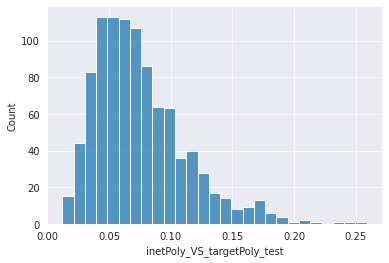

In [35]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50])


<AxesSubplot:xlabel='lstsqLambda_VS_targetPoly_test', ylabel='Count'>

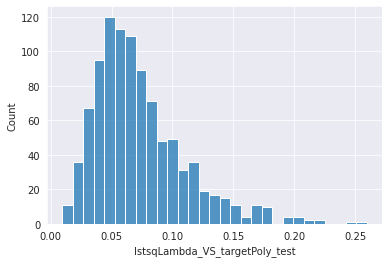

In [36]:
sns.histplot(distrib_dict_list[-1]['MAE'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50])


[(-30.0, 1.0)]

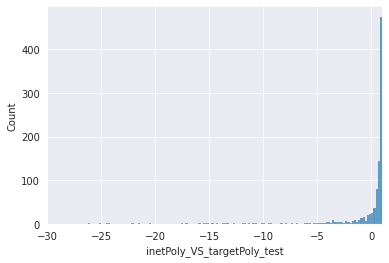

In [37]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-30, 1))

[(0.0, 1.0)]

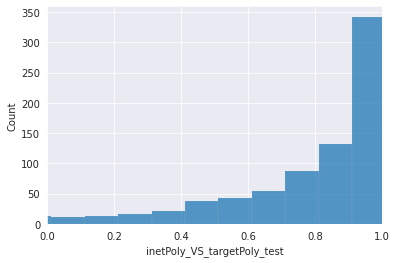

In [38]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['inetPoly_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

[(-10.0, 1.0)]

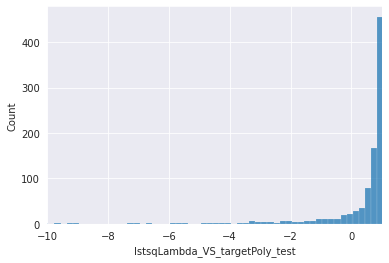

In [39]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.2)
p.set(xlim=(-10, 1))

[(0.0, 1.0)]

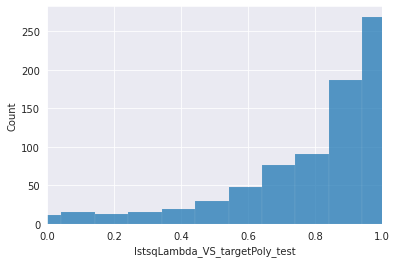

In [40]:
p = sns.histplot(distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'][distrib_dict_list[-1]['R2'].loc['lstsqLambda_VS_targetPoly_test'] > -50], binwidth=0.1)
p.set(xlim=(0, 1))

In [41]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


In [42]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    if consider_labels_training or evaluate_with_real_function:
        plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + path_identifier_interpretation_net_data + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [43]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [44]:
if len(scores_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list)

In [45]:
if len(scores_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [46]:
index = 5

polynomial_target = lambda_net_test_dataset.target_polynomial_list[index]
polynomial_lstsq_target = lambda_net_test_dataset.lstsq_target_polynomial_list[index]
polynomial_lstsq_lambda = lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list[index]
polynomial_inet = inet_preds_test_list[-1][index]

print('Target Poly:')
print_polynomial_from_coefficients(polynomial_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Target Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_target, force_complete_poly_representation=True, round_digits=4)
print('LSTSQ Lambda Poly:')
print_polynomial_from_coefficients(polynomial_lstsq_lambda, force_complete_poly_representation=True, round_digits=4)
print('I-Net Poly:')
print_polynomial_from_coefficients(polynomial_inet, round_digits=4)


Target Poly:


-0.0055*a**1.0 - 0.5873*a**2.0 - 0.937*a**3.0 - 0.067*a**4.0 + 0.5663

LSTSQ Target Poly:


0.5056*a**1.0 - 0.7015*a**2.0 - 7.925*a**3.0 + 11.6032*a**4.0 - 4.9158*a**5.0 + 0.5512

LSTSQ Lambda Poly:


0.5056*a**1.0 - 0.7015*a**2.0 - 7.925*a**3.0 + 11.6032*a**4.0 - 4.9158*a**5.0 + 0.5512

I-Net Poly:


0.282799988985062*a**1.0 - 1.55719995498657*a**2.0 - 0.931999981403351*a**3.0 + 0.470299988985062*a**4.0 + 0.365200012922287*a**5.0 + 0.552799999713898

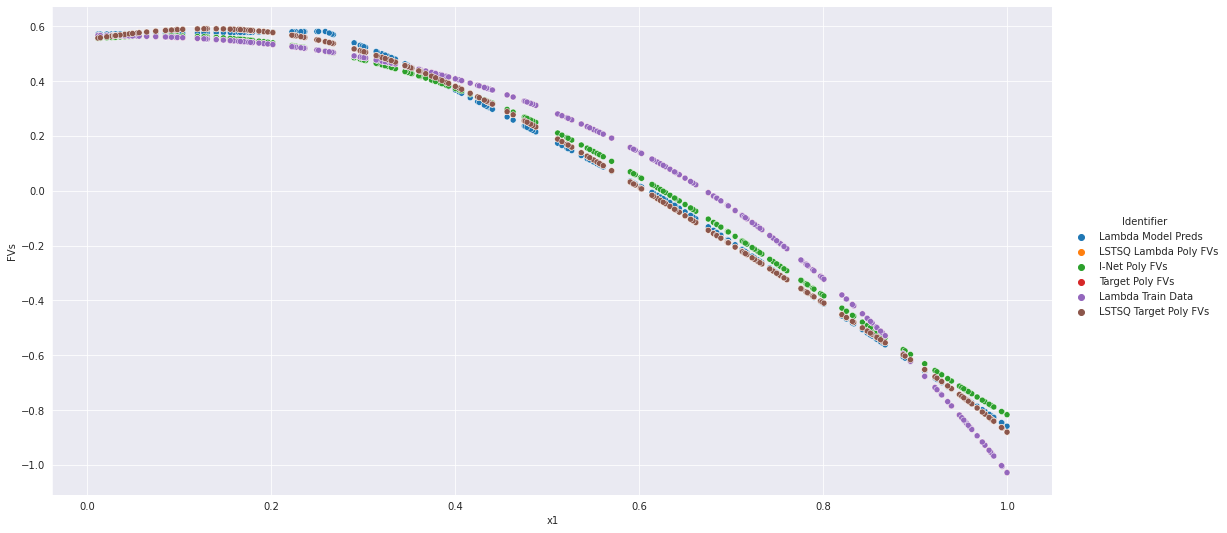

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.00980114021875861 | 0.9993808102508852 |   -    |   0.5056*a**1.0 - 0.7015*a**2.0 - 7.925*a**3.0 +   |
|            vs.            |                     |                    |        |      11.6032*a**4.0 - 4.9158*a**5.0 + 0.5512       |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |                                                    |
|                           |                     |                    |        |                                                    |
|       Lambda Preds        | 0.02946710485960798 | 0.9

In [47]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=1)

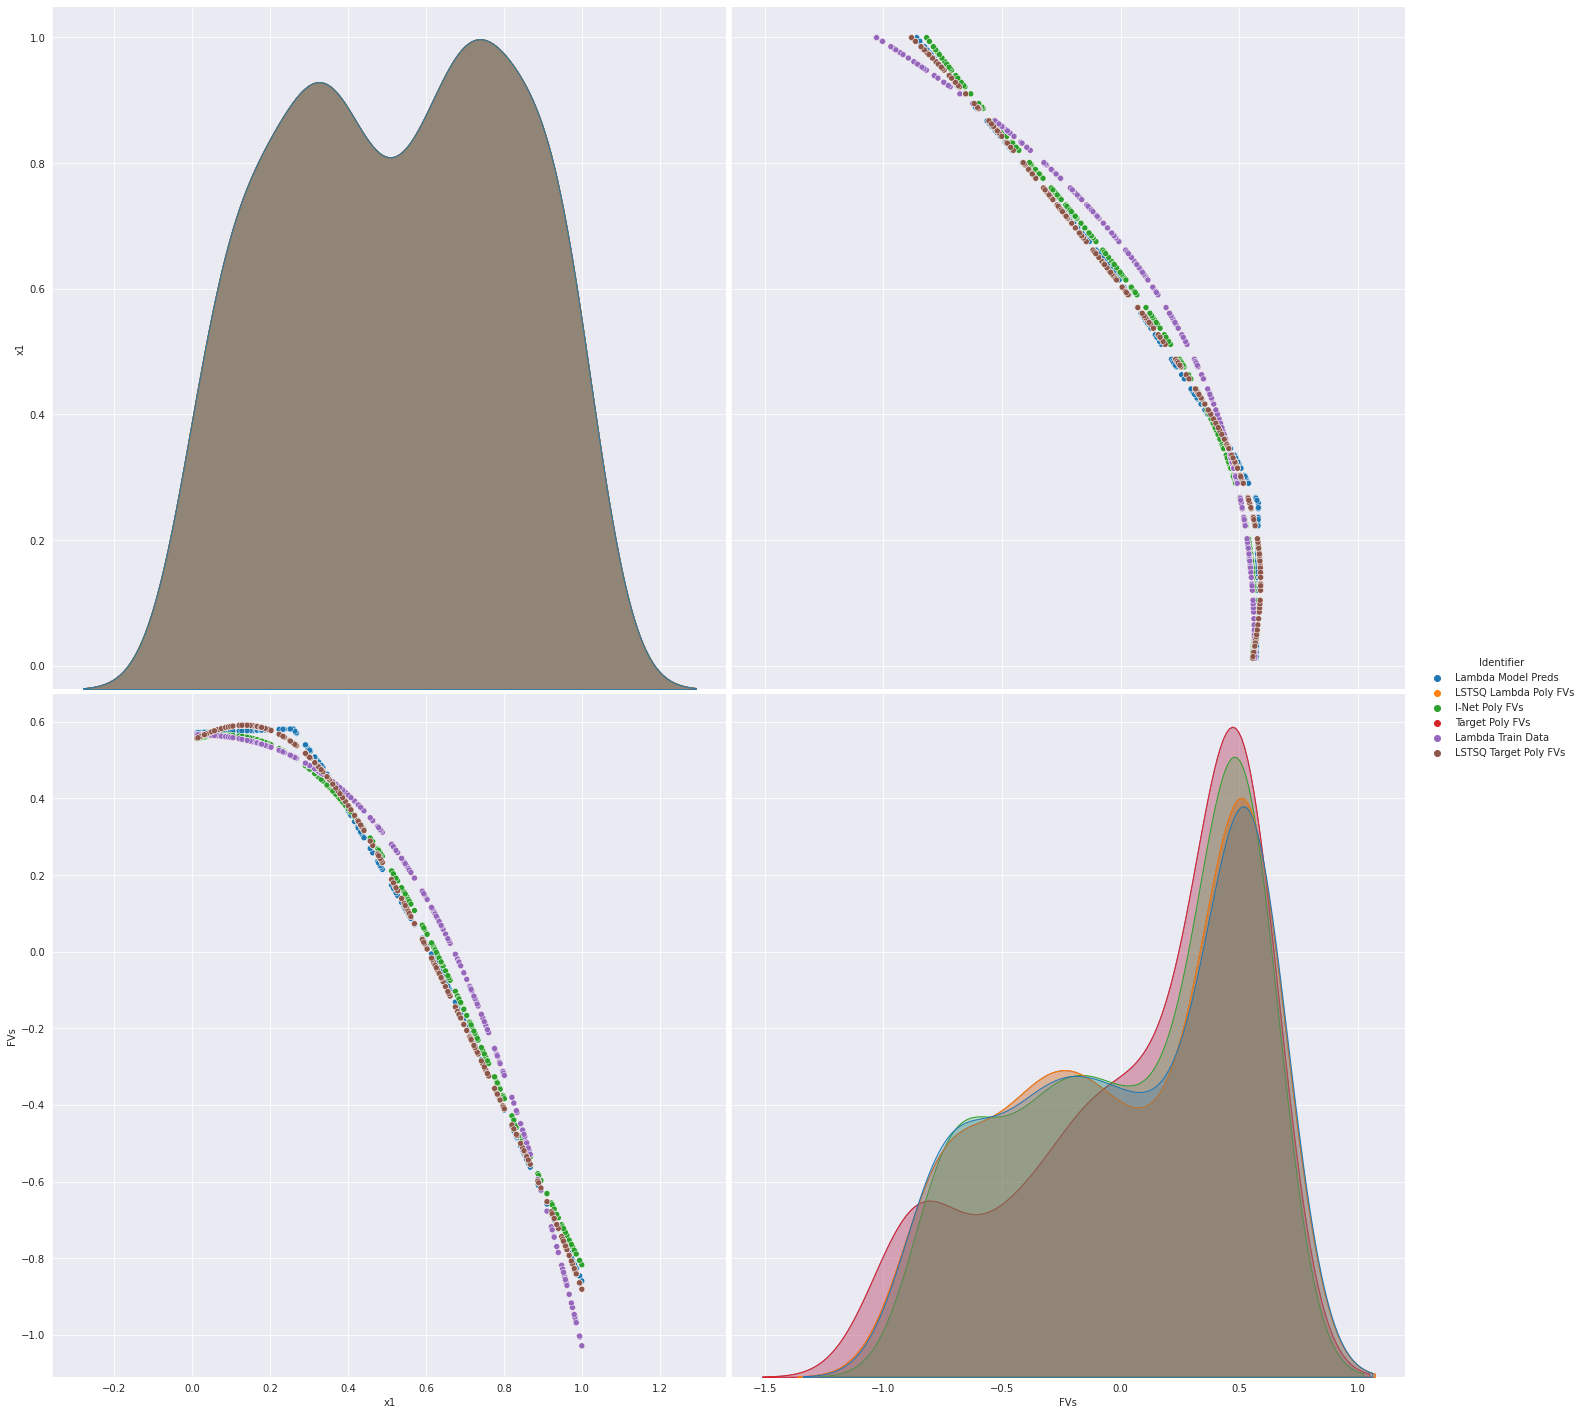

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.00980114021875861 | 0.9993808102508852 |   -    |   0.5056*a**1.0 - 0.7015*a**2.0 - 7.925*a**3.0 +   |
|            vs.            |                     |                    |        |      11.6032*a**4.0 - 4.9158*a**5.0 + 0.5512       |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |                                                    |
|                           |                     |                    |        |                                                    |
|       Lambda Preds        | 0.02946710485960798 | 0.9

In [48]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=2)

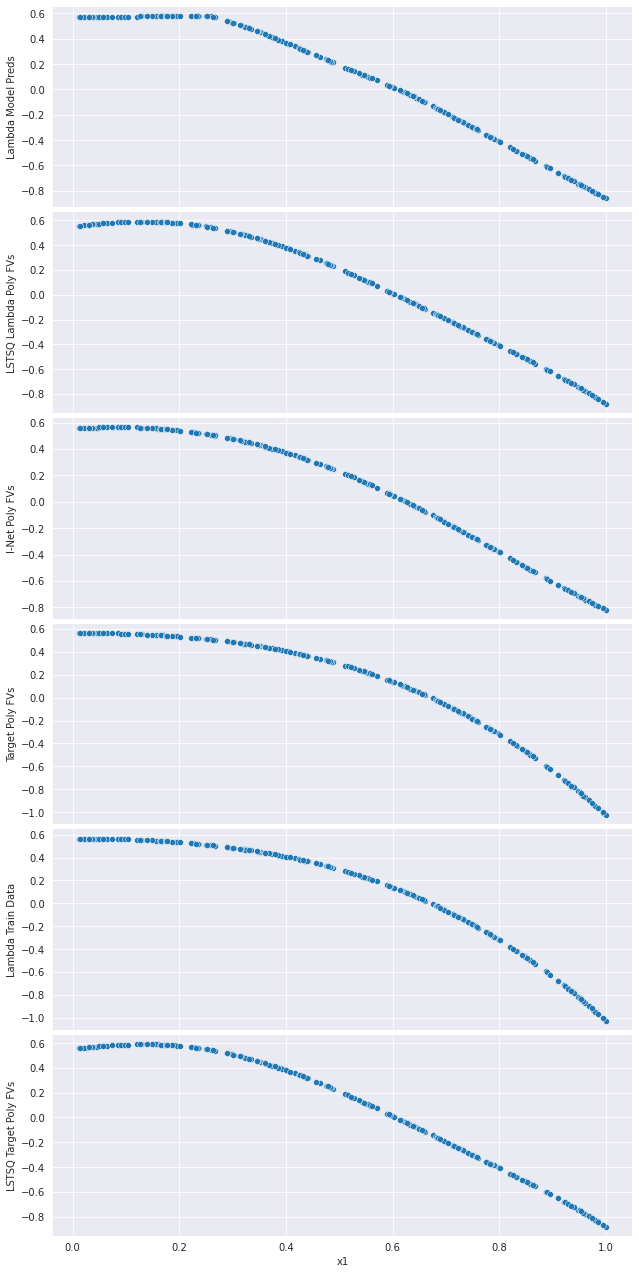

+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|         Comparison        |         MAE         |      R2-Score      | Poly 1 |                       Poly 2                       |
+---------------------------+---------------------+--------------------+--------+----------------------------------------------------+
|       Lambda Preds        | 0.00980114021875861 | 0.9993808102508852 |   -    |   0.5056*a**1.0 - 0.7015*a**2.0 - 7.925*a**3.0 +   |
|            vs.            |                     |                    |        |      11.6032*a**4.0 - 4.9158*a**5.0 + 0.5512       |
|  LSTSQ Lambda Preds Poly  |                     |                    |        |                                                    |
|                           |                     |                    |        |                                                    |
|       Lambda Preds        | 0.02946710485960798 | 0.9

In [49]:
plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                      function_values_test_list, 
                                                      inet_preds_test_list,
                                                      rand_index=index, 
                                                      plot_type=3)

# BENCHMARK (RANDOM GUESS) EVALUATION

In [50]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [51]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

In [52]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

Random Guess Error Coefficients: 5.0219


In [53]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

Random Guess Error FVs: 6.266


# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [54]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [55]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

Educated Guess/Mean Prediction Error FVs: 0.5499


In [56]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [57]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()